Kernel: PYTORCH 2.0.0 Python 3.10 CPU Kernel, ml.m5.large

# Customize Whisper to add support for new languages


In this workshop we will train a Whisper Tiny model on a new language, Gaeilge 

In this section we will launch a realtime inference endpoint, a managed endpoint that will expose our finetuned model as an api

We will:

1. Deploy the model from the finetuning job into a inference endpoint
2. Convert a test mp3 file into the format supported by the Whisper model
3. Run inference
4. Compare with the previous and expected results

In [ ]:
# Install librosa (to process mp3) and upgrade sagemaker
!pip install librosa pydub
!pip install sagemaker --upgrade 

In [ ]:

import sagemaker.huggingface

#BUCKET="[BUCKET_NAME]" # please use your bucket name
ROLE = sagemaker.get_execution_role()
sess = sagemaker.Session()
BUCKET = sess.default_bucket()
print(f"sagemaker role arn: {ROLE}")
print(f"sagemaker bucket: {BUCKET}")
print(f"sagemaker session region: {sess.boto_region_name}")

## Before proceding in the next step: 
pick the model archive artifact form the Sagemaker Training job
https://us-east-1.console.aws.amazon.com/sagemaker/home#/jobs

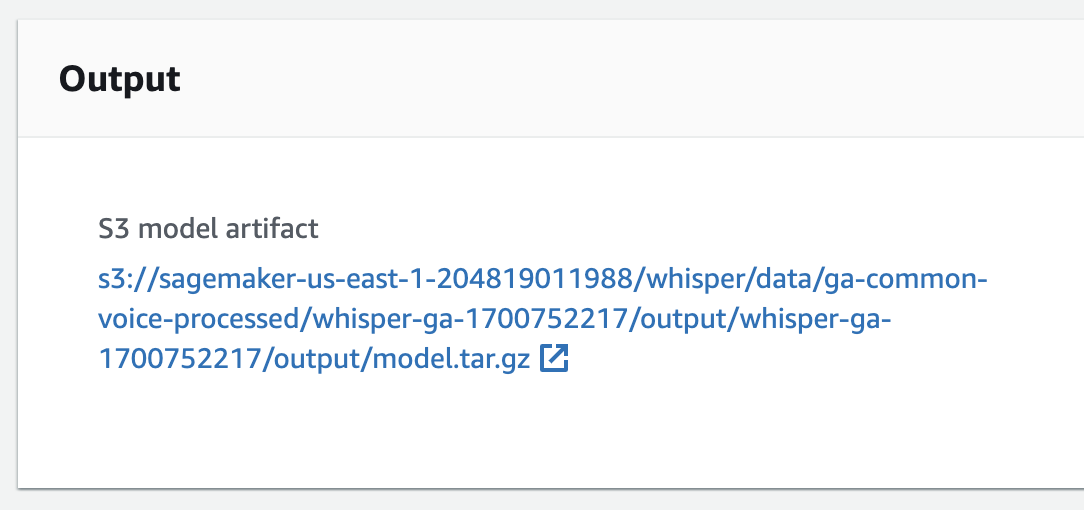

In [ ]:
# Launch Realtime Inference Endpoint
# The SageMaker Model is a container containing the running environment + inference scripte + model data.
# The SageMaker Endpoint is a running cluster of the SageMaker Models

from sagemaker.huggingface import HuggingFaceModel

# Change model_name (create one) and model_data (copy from the training job S3 model artifact) accordingly
model_name = 'wishperer-tiny'
model_data =  raise  # will be something like 's3://sagemaker-us-east-1-566765136679/whisper/data/ga-common-voice-processed/whisper-ga-1700694190/output/whisper-ga-1700694190/output/model.tar.gz'
endpoint_name = 'whisper-ge'

image = sagemaker.image_uris.retrieve(
    framework='pytorch',
    region=sess.boto_region_name,
    image_scope='inference',
    version='2.0.0',
    instance_type="ml.m5d.2xlarge",
)


huggingface_model = HuggingFaceModel(
        entry_point = 'inference.py',
        source_dir='./scripts',
        name = model_name,
        image_uri=image,
        transformers_version='4.28.1',
        pytorch_version='2.0.0',
        py_version='py310',
        model_data=model_data,
        role=ROLE,
    )



In [ ]:
# The create_model method takes a lot of temporary space under the root. For large models, the root disk in SageMaker Studio Notebook (which is a container) is not enough. 
# This notebook is simply invoking SageMaker APIs, so it can be done on a EC2 as well.

# For creating a new model and deploy as a new endpoint, the easiest way is to call the deploy method under the model
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5d.2xlarge",
    endpoint_name = endpoint_name,
)

# If you want to update an existing endpoint with a new model, you 
# from sagemaker.predictor import Predictor
# from sagemaker.serializers import DataSerializer
# from sagemaker.deserializers import JSONDeserializer
#
# sess.create_model(
#     model_name,
#     ROLE,
#     huggingface_model.prepare_container_def(
#         instance_type='ml.m5d.2xlarge'
#     )
# )
#
# audio_serializer = DataSerializer(content_type='audio/x-audio')
#
# predictor = Predictor('whisper-ge', serializer=audio_serializer, deserializer=JSONDeserializer())
# predictor.update_endpoint(model_name=endpoint_name, initial_instance_count=1, instance_type='ml.m5d.2xlarge')

In [ ]:
%%time
# Do the prediction
from sagemaker.predictor import Predictor
from sagemaker.serializers import DataSerializer
from pydub import AudioSegment
audio_path = 'test_audio.flac'
audio_serializer = DataSerializer(content_type='audio/x-audio')

predictor = Predictor(endpoint_name, serializer=audio_serializer)
audio_data = AudioSegment.from_mp3('test_audio.mp3')
audio_data.export('test_audio.flac', format = "flac")

with open(audio_path, "rb") as data_file:
    audio_data = data_file.read()
prediction = predictor.predict(audio_data)


In [ ]:
# expected Tá peann agamsa agus tá peann agatsa agus is linn féin iad
# baseline Topiaonagomsa Augustopiaonagomsa Augustopiaonagomsa August is Linfane Ed
print(prediction.decode('unicode_escape'))

In [ ]:
# Clean up resources
predictor.delete_endpoint()